In [22]:
import tensorflow as tf
import numpy as np
import tempfile
import cv2
import matplotlib.pyplot as plt
from glob import glob

---
## 1. *make_example*, *parse_example* functionalities

In [25]:
def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=value))


def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def make_img_example(img, onehot_labels):
    """
    create a single tf.train.Example obj instance given a single input sample
    in the form of sequence & labels pair.
    """    
    # # preprocess sequence
    # sequence = preprocess_seq(sequence)
    # convert sequence (string) to list of tokens ex.[string, ..., string]
    img_raw = tf.compat.as_bytes(img.tostring())
    height, width = img.shape[:2]
    labels = np.array(onehot_labels).tostring()
    img_features = {
                     "height": _int64_feature([height]),
                     "width" : _int64_feature([width]),
                     "image" : _bytes_feature([img_raw]),
                     "labels": _bytes_feature([labels])
                   }
    example = tf.train.Example(features=tf.train.Features(feature=img_features))
    return example


def parse_img_example(record):
    """
    """
    keys_to_features = {
        "image" : tf.FixedLenFeature((), tf.string, default_value=""),
        "height": tf.FixedLenFeature((), tf.int64),
        "width" : tf.FixedLenFeature((), tf.int64),
        "labels": tf.FixedLenFeature((), tf.string)
    }    
    features = tf.parse_single_example(record, keys_to_features)
    
    # convert features to tensors
    image = tf.decode_raw(features['image'], tf.uint8)
    height = tf.cast(features['height'], tf.int64)
    width = tf.cast(features['width'], tf.int64)
    labels = tf.decode_raw(features['labels'], tf.int64)

    # reshape input to original dimensions and cast image to type float
    image = tf.cast(tf.reshape(image, (height, width, 3), name="image_reshape"), dtype=tf.float32)

    # reshape images to same shape
    image = tf.image.resize_image_with_crop_or_pad(image, target_height=128, target_width=128)
    
    return image, labels

### 1.1 Example usage of make_example and parse_exmp

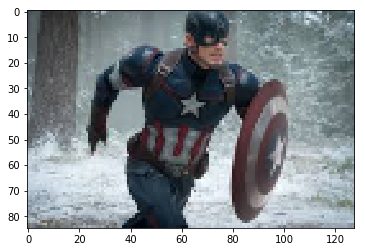

In [26]:
TARGET_DIM = 128

# load a single image from file
sample_img = cv2.imread('img_dataset/avengers4.jpg')
sample_img = cv2.cvtColor(sample_img, cv2.COLOR_BGR2RGB)
# compute the rescale factor
scale_factor = TARGET_DIM/max(sample_img.shape)
# resize image
sample_img = cv2.resize(sample_img, (0,0), fx=scale_factor, fy=scale_factor)
plt.imshow(sample_img)
plt.show()

#### Make tf Example

In [27]:
# make tf example obj
ex = make_img_example(img=sample_img,
                      onehot_labels=[1,0,0,0,0])

# view serialize the tf example obj
ex_serial = ex.SerializeToString()
print('Serialized Example:\n{}..........................{}'.format(ex_serial[:100], ex_serial[-100:]))
print()

Serialized Example:
b'\n\xf1\xff\x01\n6\n\x06labels\x12,\n*\n(\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\n\x93\xff\x01\n\x05image\x12\x88\xff\x01\n\x84\xff\x01\n\x80\xff\x01INTGPUKVXOZ\\NXY:?'..........................b'\x8f\x91\x9dvx\x84\x88\x8a\x96\x85\x87\x93{}\x89\x85\x87\x93\x85\x8e\x95\x83\x8c\x93\x8c\x96\x9e\xa4\xae\xb7\x98\xa5\xae\x96\xa4\xaf\x95\xa3\xae\xa2\xae\xbc\x9b\xa7\xb5\x97\xa3\xb1\x95\xa1\xaf\x99\xa5\xb3\x9e\xaa\xb8\x8f\x9b\xa9\x87\x93\xa1\x8d\x99\xa5\n\x0f\n\x05width\x12\x06\x1a\x04\n\x02\x80\x01\n\x0f\n\x06height\x12\x05\x1a\x03\n\x01U'



#### Parse tf Example

In [28]:
print('Tensors Returned From Parse_exmp:')

# parse example
image_tensor, labels_tensor = parse_img_example(ex_serial)

# examine obj type
print('image: ',image_tensor)
print('labels: ',labels_tensor)
print()

Tensors Returned From Parse_exmp:
image:  Tensor("resize_image_with_crop_or_pad_1/Squeeze:0", shape=(128, 128, 3), dtype=float32)
labels:  Tensor("DecodeRaw_3:0", shape=(?,), dtype=int64)



Evaluated Tensor Objects:
image: 


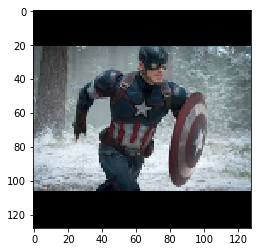

labels:
 [1 0 0 0 0]


In [29]:
# evaluate each obj
print('Evaluated Tensor Objects:')
with tf.Session() as sess:
    print('image: ')
    plt.imshow(image_tensor.eval()*255) # multiplying 
    plt.show()
    print('labels:\n', labels_tensor.eval())

And we got the original image and labels back!

---
## 2. Create a TFRecord file from input dataset

In [30]:
def make_tfrecord(data, outf_nm='my_img_dataset'):
    """
    data is in the format of tuple (image, labels), where each image and labels
    are list objects of image arrays and one-hot labels, respectively
    """
    images, labels = data
    outf_nm += '.tfrecord'
    tfrecord_wrt = tf.python_io.TFRecordWriter(outf_nm)
    n_samples = len(labels)
    for i in range(n_samples):
        exmp = make_img_example(images[i], labels[i])
        exmp_serial = exmp.SerializeToString()
        tfrecord_wrt.write(exmp_serial)

In [31]:
img_files = glob('img_dataset/avengers*.jpg')
image_list = []
for i in range(len(img_files)):
    img = cv2.cvtColor(cv2.imread(img_files[i]), cv2.COLOR_BGR2RGB)
    # compute the rescale factor
    scale_factor = TARGET_DIM/max(img.shape)
    # resize image
    img = cv2.resize(img, (0,0), fx=scale_factor, fy=scale_factor)
    image_list.append(img)
    
# assumed labels
labels_list = [[0,1,0,0,0,0], [0,0,1,0,0,0], [1,0,0,0,0,0],[0,0,0,0,1,0], [0,0,0,0,0,1], [0,1,0,0,0,0],
               [0,1,0,0,0,0], [0,0,1,0,0,0], [1,0,0,0,0,0],[0,0,0,0,1,0], [0,0,0,0,0,1], [0,1,0,0,0,0],
               [0,1,0,0,0,0], [0,0,1,0,0,0], [1,0,0,0,0,0],[0,0,0,0,1,0], [0,0,0,0,0,1], [0,1,0,0,0,0]]

In [32]:
# create TFRecord file
dataset = (image_list, labels_list)
make_tfrecord(dataset)

---
## 3. Using the TFRecord file to create TFDataset

In [33]:
# create a tf dataset obj from the TFRecord file
dataset = tf.data.TFRecordDataset('my_img_dataset.tfrecord')

# use dataset.map() in conjunction with the parse_exmp function created earlier
# to de-serialize each example record in TFRecord file
dataset = dataset.map(parse_img_example)

In [34]:
# configure the dataset to set # of epoch, shuffle, and batch size 
epochs = 3
buffer_size = len(image_list)
batch_size = 10

# configure dataset epoch, shuffle, padding and batching operations
dataset = dataset.repeat(epochs).shuffle(buffer_size).batch(batch_size)

In [35]:
dataset.output_types

(tf.float32, tf.int64)

In [36]:
dataset.output_shapes

(TensorShape([Dimension(None), Dimension(128), Dimension(128), Dimension(3)]),
 TensorShape([Dimension(None), Dimension(None)]))

Evaluated Tensor Objects:


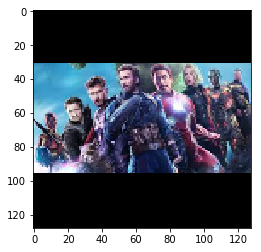

labels: [1 0 0 0 0 0]


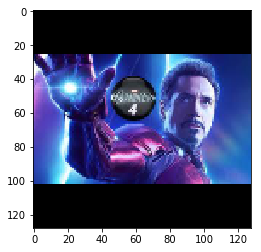

labels: [0 0 0 0 1 0]


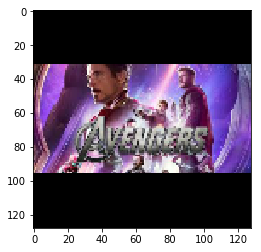

labels: [0 0 0 0 0 1]


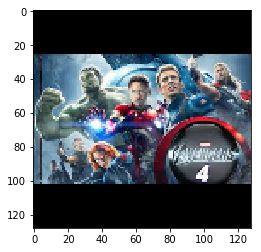

labels: [0 1 0 0 0 0]


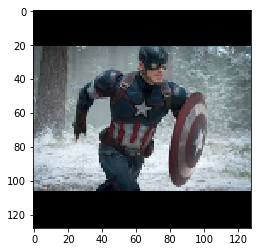

labels: [1 0 0 0 0 0]


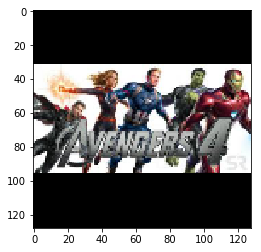

labels: [0 1 0 0 0 0]


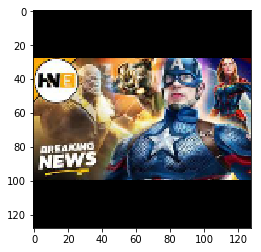

labels: [0 0 0 0 0 1]


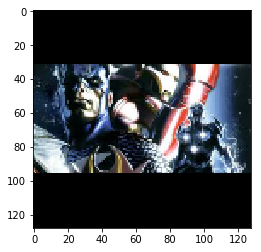

labels: [0 0 0 0 1 0]


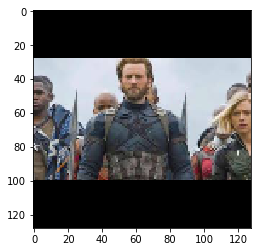

labels: [0 1 0 0 0 0]


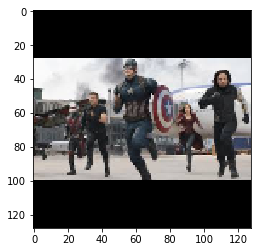

labels: [0 1 0 0 0 0]


In [37]:
# create a one-shot iterator to parse out one single record example at a time
iterator = dataset.make_one_shot_iterator()
image, labels = iterator.get_next()

# evaluate each obj
print('Evaluated Tensor Objects:')
with tf.Session() as sess:
    avenger_images = image.eval()
    avenger_labels = labels.eval()

for img, l in zip(avenger_images, avenger_labels):
    plt.imshow(img*255)
    plt.show()
    print('labels: {}'.format(l))